In [55]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model

base_dir = "C:/Users/Xin/Dropbox/BrainImaging_ML/"
# base_dir = "/home/xin/Dropbox/BrainImaging_ML/"
data_dir = base_dir + "data"

# input_dir = "/home/xin/Dropbox/BrainImaging_ML/multidimensional_age_prediction/out03_age_prediction"
input_dir = "out03_age_prediction_hc2_stdz_age_reverse_fa_scale_thresh0.02"
# input_dir = "out03_age_prediction_hc3_stdz_age_reverse_fa"

# model = 'vvi2'
model = 'cluster_gmm_eii4'
# model = 'cluster_gmm' # for sklearn reuslts
# model = 'cluster_km'
method = 'ridge'
# method = 'svrlinear'


# select a more strict criterion for HCs:
hc_column = 'mental_hc2'

## Healthy control:
scatter_data_hc = pd.read_csv(input_dir+"/out03_scatter_data_" + method + "_" + model + ".csv", 
                              sep = ",", header = 0, index_col=0)
scatter_data_hc['group'] = 'HC'
scatter_data_hc['Sex'] = (scatter_data_hc['Sex']+1)/2
scatter_data_hc['Sex'].astype('int32')

# select mental healthy subjects:
behav_data = pd.read_csv(data_dir+"/pyresult01_pnc_behav_mental4.csv", delimiter = ",")
behav_data = behav_data.astype({'SUBJID': 'int64'})
behav_data["Med_Rating"] = behav_data["Med_Rating"].apply(pd.to_numeric, errors='coerce')
behav_data = behav_data.loc[behav_data["Med_Rating"]<2,:]

behav_data_hc = behav_data.loc[behav_data[hc_column]==True, 'SUBJID']

## select a subset of strict HCs:
scatter_data_hc = scatter_data_hc.loc[scatter_data_hc['SUBJID'].isin(behav_data_hc),:]

## disorder groups:
scatter_data = pd.read_csv(input_dir+"/out03_scatter_data_" + method + "_disorder_" + model + ".csv", 
                           sep = ",", header = 0, index_col=0)

## combine hc and disorder groups:
scatter_data = pd.concat([scatter_data_hc, scatter_data])
scatter_data["cluster"].apply(pd.to_numeric, errors='coerce')
# scatter_data['cluster'].astype('int32')

cluster_idx = scatter_data['cluster'].unique()
num_cluster = len(cluster_idx)

# scatter_data.set_index('cluster', inplace = True)
# scatter_data.sort_index(inplace = True)

# scatter_data.index.astype('str') 
scatter_data['group'].unique()

array(['HC', 'smry_ptd', 'smry_dep', 'smry_phb', 'smry_soc', 'smry_add',
       'smry_odd'], dtype=object)

In [56]:
scatter_data_hc

,cluster,SUBJID,CV,chronological age,brain age,Sex,group
0,1.0,600009963128,1,9.0,11.808093,0.0,HC
1,1.0,600110937794,1,10.0,8.479889,0.0,HC
2,1.0,600409285352,1,16.0,18.629807,1.0,HC
3,1.0,600647003585,1,18.0,15.968194,0.0,HC
4,1.0,600883641613,1,19.0,18.449981,1.0,HC
...,...,...,...,...,...,...,...
50,all,608993118659,3,19.0,16.069533,0.0,HC
51,all,609072841451,3,18.0,15.422518,0.0,HC
52,all,609485506588,3,20.0,16.221753,0.0,HC
53,all,609575311394,3,12.0,14.426890,1.0,HC


In [57]:
scatter_data['cluster'].unique()

array(['1.0', '2.0', '3.0', '4.0', 'all'], dtype=object)

In [58]:
# fit brain age to do bias correction for brain age gap:

cluster_list = scatter_data['cluster'].unique()
regr = linear_model.LinearRegression()

for icluster in cluster_list:

    scatter_data_cluster = scatter_data.loc[scatter_data['cluster']==icluster,:]

    y_train = scatter_data_cluster.loc[:,'brain age'].values
    X_train = np.hstack((scatter_data_cluster.loc[:,['Sex', 'chronological age']].values,
                         np.vstack((scatter_data_cluster.loc[:,'chronological age'].values**2))))

    ####### fit model with sex and interaction terms:
    X_train = np.hstack((X_train,
                         np.vstack((X_train[:,0]*X_train[:,1])), 
                         np.vstack((X_train[:,0]*X_train[:,2]))))

    # Train the model using the training set
    regr.fit(X_train, y_train)

    # Make predictions using the training set
    y_pred = regr.predict(X_train)
    
    scatter_data.loc[scatter_data['cluster']==icluster, 'brain age fit intersex'] = y_pred

#scatter_data.to_csv(input_dir+'out04_healthy_controls_age_fit.csv')
scatter_data['age gap'] = scatter_data['brain age'] - scatter_data['chronological age']
scatter_data['age gap corr'] = scatter_data['brain age'] - scatter_data['brain age fit intersex']

scatter_data.reset_index(inplace = True)
scatter_data.replace({'Sex': {0: 'F', 1: 'M'}}, inplace = True)

scatter_data.to_csv(input_dir+"/out04_scatter_data_" + method + "_" + model +"_fit_brain_age.csv")


In [59]:
scatter_data['group'] = scatter_data['group'].map({'HC': 'HC',
                                                   'smry_phb': 'Specific phobia', 
                                                   'smry_soc': 'Social phobia',
                                                   'smry_dep': 'Depression',
                                                   'smry_ptd': 'PTSD',
                                                   'smry_odd': 'ODD',
                                                   'smry_add': 'ADHD'})

scatter_data['cluster2'] = scatter_data['cluster'].map({'1.0': 'cluster 1',
                                                       '2.0': 'cluster 2',
                                                       '3.0': 'cluster 3',
                                                       '4.0': 'cluster 4',
                                                       'all': 'cluster all',
                                                      })

column_title = ['cluster ' + str(n) for n in range(1, num_cluster)] + ['cluster all']
scatter_data['cluster2'] = pd.Categorical(scatter_data['cluster2'], ordered=True, categories=column_title)
# cat_type = CategoricalDtype(categories=column_title, ordered=True)
# scatter_data['cluster2'] = scatter_data['cluster2'].astype(cat_type)

# cat_type = CategoricalDtype(categories=['HC', 'Specific phobia', 'Social phobia', 'Depression', 'PTSD', 'ODD', 'ADHD'], 
#                             ordered=True)
# scatter_data['group2'] = scatter_data['group'].astype(cat_type)

scatter_data['group2'] = pd.Categorical(scatter_data['group'], ordered=True,
                                        categories=['HC', 'Specific phobia', 'Social phobia', 'Depression', 'PTSD', 'ODD', 'ADHD'])


# scatter_data

In [60]:
demo_summary_gender = scatter_data.loc[scatter_data['cluster2']=='cluster 1',
                                      ['chronological age', 'Sex', 'group']].groupby(['Sex', 'group']).agg(['mean', 'count', 'std'])

demo_summary_female = demo_summary_gender.loc[('F',),].reindex(['HC', 'Specific phobia', 
                                                                'Social phobia', 'Depression',
                                                                'PTSD', 'ODD', 'ADHD'])
demo_summary_female
demo_summary_female.loc[:,('chronological age', 'count')]

demo_summary = scatter_data.loc[scatter_data['cluster2']=='cluster 1', 
                                ['chronological age', 'Sex', 'group']].groupby(['group']).agg(['count', 'mean', 'std'])

demo_summary = demo_summary.reindex(['HC', 'Specific phobia', 'Social phobia', 'Depression', 'PTSD', 'ODD', 'ADHD'])
demo_summary = demo_summary.reset_index()
demo_summary.columns = ['group', 'sample size', 'age (mean)', 'age (std)']
demo_summary.insert(2, "females", demo_summary_female.loc[:,('chronological age', 'count')].values)
demo_summary

,group,sample size,females,age (mean),age (std)
0,HC,166,82,14.506024,3.794329
1,Specific phobia,185,120,13.600000,3.191701
2,Social phobia,142,82,14.457746,2.829989
3,Depression,70,47,16.000000,2.407717
4,PTSD,71,51,15.507042,2.724876
5,ODD,206,112,14.359223,2.519599
6,ADHD,106,51,13.377358,2.983934


In [68]:
scatter_data.pivot(index='SUBJID', columns='group', values=['baz', 'zoo'])

ValueError: Length mismatch: Expected 4730 rows, received array of length 2

In [67]:
# check for subjects with comorbidity:
scatter_data

scatter_data_duplicated = scatter_data[scatter_data.duplicated(subset = ['SUBJID', 'cluster'], keep = False)]
print(scatter_data_duplicated['group'].unique())
scatter_data_spec_soci = scatter_data_duplicated[scatter_data_duplicated['group'].isin(['Specific phobia', 'Social phobia'])]
scatter_data_spec_soci

['PTSD' 'Depression' 'Specific phobia' 'Social phobia' 'ADHD' 'ODD']


,index,cluster,SUBJID,CV,chronological age,brain age,Sex,group,brain age fit intersex,age gap,age gap corr,cluster2,group2
971,5,1.0,600039665619,NaN,9.0,10.480894,M,Specific phobia,9.819993,1.480894,0.660901,cluster 1,Specific phobia
972,7,1.0,600045443700,NaN,17.0,15.468851,F,Specific phobia,16.544897,-1.531149,-1.076046,cluster 1,Specific phobia
974,18,1.0,600110501017,NaN,14.0,14.366459,M,Specific phobia,14.839508,0.366459,-0.473049,cluster 1,Specific phobia
975,27,1.0,600129552715,NaN,11.0,12.757564,F,Specific phobia,12.511364,1.757564,0.246200,cluster 1,Specific phobia
976,34,1.0,600210241146,NaN,18.0,19.529461,F,Specific phobia,16.829743,1.529461,2.699718,cluster 1,Specific phobia
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4411,905,all,609541974512,NaN,9.0,9.230807,M,Social phobia,9.446424,0.230807,-0.215617,cluster all,Social phobia
4412,911,all,609596578924,NaN,14.0,12.813317,M,Social phobia,15.006886,-1.186683,-2.193569,cluster all,Social phobia
4413,915,all,609629088732,NaN,10.0,11.614270,F,Social phobia,11.248782,1.614270,0.365489,cluster all,Social phobia
4414,925,all,609727737234,NaN,20.0,17.548881,F,Social phobia,17.035853,-2.451119,0.513027,cluster all,Social phobia


In [66]:
scatter_data_duplicated = scatter_data[scatter_data.duplicated(subset = ['SUBJID', 'cluster'], keep = False)]
print(scatter_data_duplicated['group'].unique())
scatter_data_duplicated

['PTSD' 'Depression' 'Specific phobia' 'Social phobia' 'ADHD' 'ODD']


,index,cluster,SUBJID,CV,chronological age,brain age,Sex,group,brain age fit intersex,age gap,age gap corr,cluster2,group2
830,26,1.0,600129552715,NaN,11.0,12.757564,F,PTSD,12.511364,1.757564,0.246200,cluster 1,PTSD
831,33,1.0,600210241146,NaN,18.0,19.529461,F,PTSD,16.829743,1.529461,2.699718,cluster 1,PTSD
833,71,1.0,600689706588,NaN,16.0,14.533774,F,PTSD,16.149362,-1.466226,-1.615589,cluster 1,PTSD
836,103,1.0,601146803700,NaN,12.0,12.096447,F,PTSD,13.460340,0.096447,-1.363893,cluster 1,PTSD
838,109,1.0,601167369441,NaN,14.0,14.756245,F,PTSD,15.026228,0.756245,-0.269983,cluster 1,PTSD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4722,918,all,609635211319,NaN,13.0,11.160819,F,ODD,14.147853,-1.839181,-2.987035,cluster all,ODD
4723,922,all,609709283657,NaN,10.0,7.903441,M,ODD,10.780764,-2.096559,-2.877322,cluster all,ODD
4726,936,all,609849166759,NaN,13.0,12.012933,F,ODD,14.147853,-0.987067,-2.134920,cluster all,ODD
4727,939,all,609903870257,NaN,14.0,16.238367,M,ODD,15.006886,2.238367,1.231481,cluster all,ODD


In [36]:
# remove subjects with comorbidity (with more than one disorder):
# comorbity subject were just removed from the larger disorder group.
scatter_data['group2'] = scatter_data['group'].map({'HC': 'aHC',
                                                   'Specific phobia': 'fSpecific phobia', 
                                                   'Social phobia': 'eSocial phobia',
                                                   'Depression': 'bDepression',
                                                   'PTSD': 'cPTSD',
                                                   'ODD': 'gODD',
                                                   'ADHD': 'dADHD'})

scatter_data = scatter_data.sort_values(by = ['group2'], ascending = True)
scatter_data = scatter_data.drop_duplicates(['cluster', 'SUBJID'], keep='first')


# scatter_data

In [9]:
scatter_data['group2'].unique().sort_values()

[HC, Specific phobia, Social phobia, Depression, PTSD, ODD, ADHD]
Categories (7, object): [HC < Specific phobia < Social phobia < Depression < PTSD < ODD < ADHD]

In [10]:
column_title

['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster all']

In [11]:
demo_summary_gender = scatter_data.loc[scatter_data['cluster2']=='cluster 1',
                                      ['chronological age', 'Sex', 'group']].groupby(['Sex', 'group']).agg(['mean', 'count', 'std'])

demo_summary_female = demo_summary_gender.loc[('F',),].reindex(['HC', 'Specific phobia', 
                                                                'Social phobia', 'Depression',
                                                                'PTSD', 'ODD', 'ADHD'])
demo_summary_female
demo_summary_female.loc[:,('chronological age', 'count')]

group
HC                 82
Specific phobia    46
Social phobia      43
Depression         47
PTSD               31
ODD                20
ADHD               37
Name: (chronological age, count), dtype: int64

In [12]:
demo_summary = scatter_data.loc[scatter_data['cluster2']=='cluster 1', 
                                ['chronological age', 'Sex', 'group']].groupby(['group']).agg(['count', 'mean', 'std'])

demo_summary = demo_summary.reindex(['HC', 'Specific phobia', 'Social phobia', 'Depression', 'PTSD', 'ODD', 'ADHD'])
demo_summary = demo_summary.reset_index()
demo_summary.columns = ['group', 'sample size', 'age (mean)', 'age (std)']
demo_summary.insert(2, "females", demo_summary_female.loc[:,('chronological age', 'count')].values)
demo_summary.to_csv(input_dir+"/out04_demo_summary.csv")
demo_summary

,group,sample size,females,age (mean),age (std)
0,HC,166,82,14.506024,3.794329
1,Specific phobia,70,46,12.571429,3.169471
2,Social phobia,77,43,14.051948,2.851113
3,Depression,70,47,16.000000,2.407717
4,PTSD,44,31,15.159091,2.836172
5,ODD,48,20,14.562500,2.657036
6,ADHD,81,37,13.086420,2.967312


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


def qudratic_r_squared(chro_age, brain_age):
    """
    compute the r squared of curve fit of chro_age vs. brain age.
    1. Use qudratic function to fit brain age with chronological age.
    2. Then, compute r squared of brain age and predicted brain age with qudratic fit model.
    """
    
    from scipy.optimize import curve_fit
    from sklearn.metrics import r2_score
    
    def qudratic_fun(x, a, b, c):
        return a + b*x + c*(x**2)
    
    popt, pcov = curve_fit(qudratic_fun, chro_age, brain_age)
    brain_age_pred = qudratic_fun(chro_age, popt[0], popt[1], popt[2])

    r_square = r2_score(brain_age, brain_age_pred)
    return(r_square)

def qudratic_r_squared_gender(chro_age, brain_age, gender):
    """
    compute the r squared of curve fit of chro_age vs. brain age.
    1. Use qudratic function to fit brain age with chronological age and gender.
    2. Then, compute r squared of brain age and predicted brain age with qudratic fit model.
    """
    
    from scipy.optimize import curve_fit
    from sklearn.metrics import r2_score
    
    def qudratic_fun(x, a, b, c, d, e, f):
        x1, x2 = x
        #return a + b*x1 + c*(x1**2) + d*x2 + e*x1*x2 f*(x1**2)*x2
        return a + b*x1 + c*(x1**2) + d*x2 + e*x1*x2 + f*(x1**2)*x2
    
    popt, pcov = curve_fit(qudratic_fun, (chro_age, gender), brain_age)
    brain_age_pred = qudratic_fun((chro_age, gender), popt[0], popt[1], popt[2], popt[3], popt[4], popt[5])

    r_square = r2_score(brain_age, brain_age_pred)
    return(r_square)

In [14]:
scatter_data

,index,cluster,SUBJID,CV,chronological age,brain age,Sex,group,brain age fit intersex,age gap,age gap corr,group2,cluster2
0,0,1.0,600009963128,1.0,9.0,11.808093,F,HC,10.281346,2.808093,1.526747,HC,cluster 1
547,49,4.0,609173350200,1.0,12.0,15.862661,M,HC,14.459860,3.862661,1.402801,HC,cluster 4
548,50,4.0,609259470422,1.0,10.0,12.872551,F,HC,14.076371,2.872551,-1.203820,HC,cluster 4
549,51,4.0,609262364081,1.0,13.0,15.879829,F,HC,14.522861,2.879829,1.356967,HC,cluster 4
550,52,4.0,609652761759,1.0,19.0,13.273507,F,HC,14.828817,-5.726493,-1.555310,HC,cluster 4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3098,618,3.0,606855754171,NaN,16.0,17.664755,M,ODD,16.306084,1.664755,1.358671,ODD,cluster 3
3092,593,3.0,606673058004,NaN,17.0,18.609446,M,ODD,16.803715,1.609446,1.805731,ODD,cluster 3
3090,587,3.0,606531042603,NaN,17.0,15.765918,F,ODD,16.322681,-1.234082,-0.556763,ODD,cluster 3
3087,573,3.0,606304691757,NaN,21.0,14.954472,M,ODD,17.662800,-6.045528,-2.708329,ODD,cluster 3


In [15]:
import statsmodels.api as sm
# from statsmodels.formula.api import ols
# from statsmodels.stats.anova import AnovaRM
import pingouin as pg

scatter_data2 = scatter_data.rename(columns= {'age gap corr':'BAG'})

# scatter_data2 = scatter_data2.loc[scatter_data2['cluster2']!='cluster all',:]
scatter_data2['cluster2'] = scatter_data2['cluster2'].cat.remove_unused_categories()

cluster_idx = scatter_data2['cluster2'].unique().sort_values()
num_cluster = len(cluster_idx)

# scatter_data2 = scatter_data2.loc[scatter_data2['cluster']!='all',:]

# model = ols('BAG ~ C(group)*C(cluster)', scatter_data2).fit()
# model.summary()

# aovrm2way = AnovaRM(scatter_data2, 'BAG', 'SUBJID', between = ['group'], within=['cluster'])
# res2way = aovrm2way.fit()
# print(res2way)

aov = pg.mixed_anova(data=scatter_data2, dv='BAG', between='group', within='cluster',
                     subject='SUBJID', correction='auto' )
pg.print_table(aov)



ANOVA SUMMARY

Source            SS    DF1    DF2      MS      F    p-unc  p-GG-corr             np2  eps    sphericity    W-spher    p-spher
-----------  -------  -----  -----  ------  -----  -------  ------------------  -----  -----  ------------  ---------  ----------------------
group        108.020      6    549  18.003  2.191    0.042  -                   0.023  -      -             -          -
cluster        1.315      4   2196   0.329  0.307    0.873  0.7817506132540566  0.001  0.622  False         0.161      7.447229231382461e-212
Interaction   22.398     24   2196   0.933  0.872    0.642  -                   0.009  -      -             -          -



C:\Users\Xin\Anaconda3\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [16]:
scatter_data2['cluster'].unique()

array(['1.0', '4.0', '3.0', 'all', '2.0'], dtype=object)

In [17]:
report = pd.DataFrame(columns = ['disorder', 'p value(group)', 'p value(cluster)', 'p value(interaction)']) 
group_label = list(scatter_data2['group2'].unique().sort_values())
# group_label = ['HC', 'Specific phobia', 'Social phobia', 'Depression', 'PTSD', 'ODD', 'ADHD']
report['disorder'] = group_label[1:]

i=0
for dis in group_label[1:]:
    print(dis)
    
    scatter_data_dis = scatter_data2.loc[scatter_data2['group2'].isin(['HC', dis]),:]
    aov = pg.mixed_anova(data=scatter_data_dis, dv='BAG', between='group', within='cluster',
                         subject='SUBJID', correction='auto')
    
    report.iloc[i,1:] = aov['p-unc'].values
    i+=1
    pg.print_table(aov)

Specific phobia

ANOVA SUMMARY

Source           SS    DF1    DF2      MS      F    p-unc  p-GG-corr             np2  eps    sphericity    W-spher    p-spher
-----------  ------  -----  -----  ------  -----  -------  ------------------  -----  -----  ------------  ---------  ----------------------
group        21.749      1    234  21.749  2.444    0.119  -                   0.010  -      -             -          -
cluster       2.464      4    936   0.616  0.482    0.749  0.6540756301646905  0.002  0.602  False         0.126      1.6543559026872076e-98
Interaction   8.193      4    936   2.048  1.602    0.172  -                   0.007  -      -             -          -

Social phobia

ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc  p-GG-corr              np2  eps    sphericity    W-spher    p-spher
-----------  -----  -----  -----  -----  -----  -------  -------------------  -----  -----  ------------  ---------  ---------------------
group        0.277      1

In [18]:
pd.options.display.float_format = '{:,.3f}'.format

report2 = report.copy()
# report.iloc[:,1:]=report.iloc[:,1:].mask(report.iloc[:,1:].le(0.05), report.astype(str).apply(lambda x : x.str[:5]).add('*'))

report2[report.iloc[:,1:].le(0.05)] = report2[
    report.iloc[:,1:].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

report2[report.iloc[:,1:].le(0.01)] = report2[
    report.iloc[:,1:].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')


In [19]:
report2.to_csv(input_dir+'/out03_anova_disorder_table' + method + '_' + model + '.csv')
report2

,disorder,p value(group),p value(cluster),p value(interaction)
0,Specific phobia,0.119,0.749,0.172
1,Social phobia,0.864,0.323,0.945
2,Depression,0.935,0.941,0.505
3,PTSD,0.410,0.609,0.973
4,ODD,0.017*,0.797,0.365
5,ADHD,0.915,0.582,0.997


In [20]:
# permutation test:
from mlxtend.evaluate import permutation_test

column_title = scatter_data2['cluster2'].unique().sort_values()
report_col =['disorder'] + ['p value(' + i +')' for i in column_title]
permutation_report = pd.DataFrame(columns = report_col) 
permutation_report['disorder'] = group_label[1:]

bag_hc = []

for icluster in column_title:
    ibag_hc = scatter_data2.loc[(scatter_data2['group']=='HC')&(scatter_data2['cluster2']==icluster), 'BAG']
    bag_hc.append(ibag_hc)


i=0
for dis in group_label[1:]:
    print(dis)
    p_dis = []
    for icluster in column_title:
        bag_dis1 = scatter_data2.loc[(scatter_data2['group']==dis)&(scatter_data2['cluster2']==icluster), 'BAG']

        p_dis1 = permutation_test(ibag_hc, bag_dis1, method='approximate', num_rounds=1000, seed=0)
        p_dis.append(p_dis1)
        #m_dis1 = np.mean(bag_hc1) - np.mean(bag_dis1)

    permutation_report.iloc[i,1:] = p_dis
    i+=1

print(permutation_report)



Specific phobia
Social phobia
Depression
PTSD
ODD
ADHD
          disorder p value(cluster 1) p value(cluster 2) p value(cluster 3)  \
0  Specific phobia              0.044              0.161              0.115   
1    Social phobia              0.954              0.344              0.729   
2       Depression              0.670              0.650              0.743   
3             PTSD              0.553              0.951              0.536   
4              ODD              0.034              0.012              0.127   
5             ADHD              0.808              0.715              0.964   

  p value(cluster 4) p value(cluster all)  
0              0.849                0.092  
1              0.727                0.724  
2              0.818                0.630  
3              0.489                0.386  
4              0.246                0.072  
5              0.593                0.998  


In [21]:
permutation_report2 = permutation_report.copy()
# report.iloc[:,1:]=report.iloc[:,1:].mask(report.iloc[:,1:].le(0.05), report.astype(str).apply(lambda x : x.str[:5]).add('*'))

permutation_report2[permutation_report.iloc[:,1:].le(0.05)] = permutation_report2[
    permutation_report.iloc[:,1:].le(0.05)].astype(str).apply(lambda x : x.str[:5]).add('*')

permutation_report2[permutation_report.iloc[:,1:].le(0.01)] = permutation_report2[
    permutation_report.iloc[:,1:].le(0.01)].astype(str).apply(lambda x : x.str[:5]).add('**')

permutation_report2.to_csv(input_dir+'/out03_permutation_disorder_table' + method + '_' + model + '.csv')
permutation_report2

,disorder,p value(cluster 1),p value(cluster 2),p value(cluster 3),p value(cluster 4),p value(cluster all)
0,Specific phobia,0.044*,0.161,0.115,0.849,0.092
1,Social phobia,0.954,0.344,0.729,0.727,0.724
2,Depression,0.670,0.650,0.743,0.818,0.630
3,PTSD,0.553,0.951,0.536,0.489,0.386
4,ODD,0.034*,0.012*,0.127,0.246,0.072
5,ADHD,0.808,0.715,0.964,0.593,0.998


p=0.044
p=0.092
p=0.034
p=0.012
p=0.072


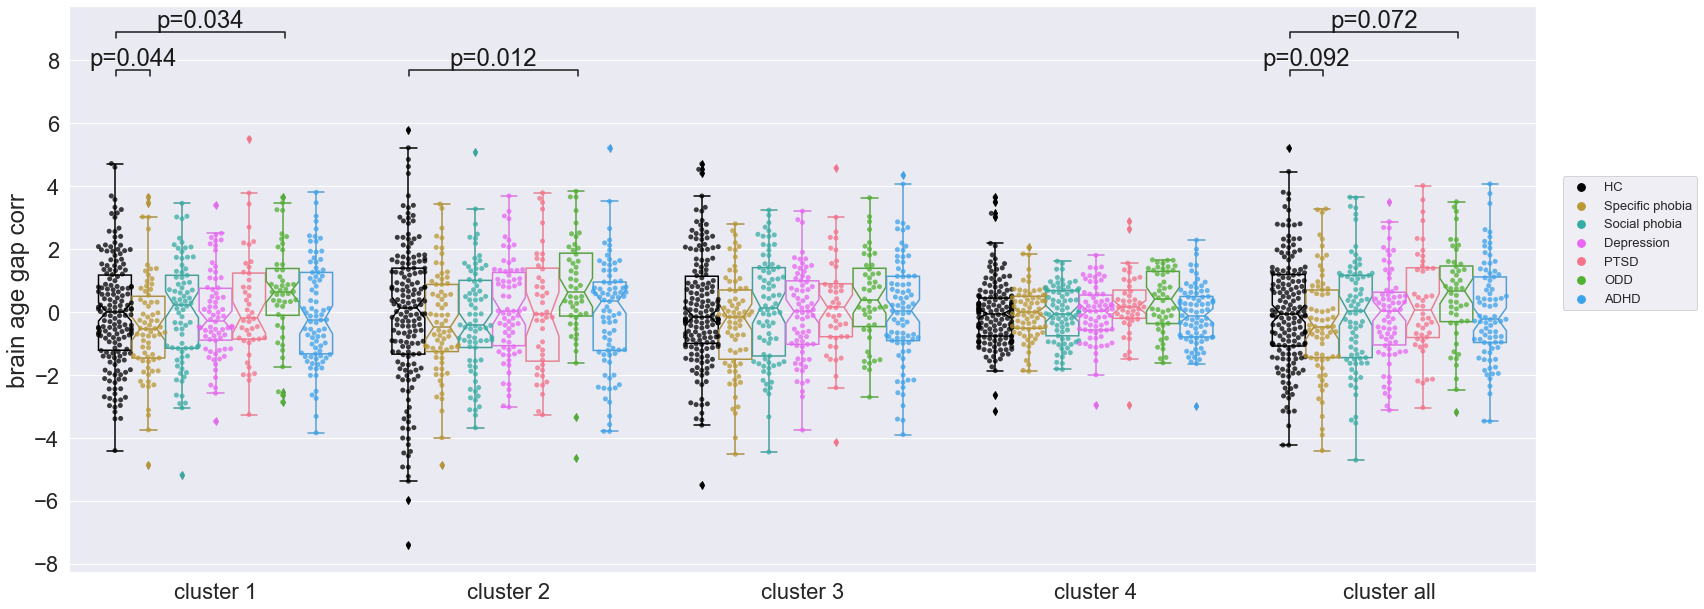

In [26]:
from statannot import add_stat_annotation

sns.set(rc={'figure.figsize':(24, 9)}, font_scale = 2)

scatter_data2 = scatter_data.rename(columns= {'age gap corr':'BAG'})
# scatter_data2 = scatter_data2.loc[scatter_data2['cluster2']!='cluster 4',:]
# scatter_data2['cluster2'] = scatter_data2['cluster2'].cat.remove_unused_categories()

# permutation_report3 = permutation_report.drop(['p value(cluster 4)'], axis=1)
permutation_report3 = permutation_report

cluster_idx = scatter_data['cluster2'].unique().sort_values()
num_cluster = len(cluster_idx)

scatter_data_group = scatter_data2[scatter_data2['group'].isin(group_label)]
scatter_data_group.to_csv(input_dir+'/out04_scatter_data_all.csv')

f, (ax1) = plt.subplots(1, sharex=True)

# x_order =  ['HC', 'smry_phb', 'smry_soc', 'smry_dep', 'smry_ptd', 'smry_odd', 'smry_add']

colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(group_label)-1).as_hex()
colors = colors[::2] + colors[1::2] 

sns.swarmplot(y = "BAG", x = "cluster2", data = scatter_data_group, 
              hue = 'group2', dodge=True, ax = ax1,
             palette = colors,#plot_kws={'scatter_kws': {'alpha': 0.1}}
             alpha = .75)

sns.boxplot(y = "BAG", x = "cluster2", data = scatter_data_group, hue = 'group2', palette = colors,
            notch = True, ax = ax1)

ax1.set(xlabel='', ylabel='brain age gap corr')

# change boxplot style:
for i,artist in enumerate(ax1.artists):
    # Set the linecolor on the artist to the facecolor, and set the facecolor to None
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('None')

    # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same colour as above
    for j in range(i*6,i*6+6):
        line = ax1.lines[j]
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)

# Also fix the legend
for legpatch in ax1.get_legend().get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor('None')
    legpatch.set_facecolor('None')

# remove legend of the boxplot
# Get the handles and labels. For this example it'll be 2 tuples
# of length 2n each.
handles, labels = ax1.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the first/last n.
n = len(group_label)
l = plt.legend(handles[n:], labels[n:], borderaxespad=0., loc = 'upper right', 
               prop = {'size': 13}, title = '',bbox_to_anchor=(1.11, 0.7), ncol=1)

# cluster_idx = ['cluster ' + str(n) for n in range(1, num_cluster)] + ['cluster all']
cluster_idx = scatter_data2['cluster2'].unique().sort_values()
comparision_pairs = [((cluster, 'HC'), (cluster, disorder)) 
                     for cluster in cluster_idx 
                         for disorder in group_label[1:]]

# add_stat_annotation(ax1, y = "age gap corr", x = "cluster", data = scatter_data, hue = 'group', 
#                     box_pairs = comparision_pairs,
#                     test='t-test_ind', 
#                     comparisons_correction = 'bonferroni',
# #                     comparisons_correction = None,
#                     line_height=0.01, fontsize='small', color='0.2', linewidth=1, 
#                     text_format='simple', loc='inside', verbose=2)

# add p value annotation manually:
def add_annot(x1, x2, y, h, p, ax, color = 'k'):
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=color)
    txt = "p=%.3f" % p
    print(txt)
    ax.text((x1+x2)*.5, y+h, txt, ha='center', va='bottom', color=color)


y_base = np.array([1]*num_cluster)*7.5

for dis in range(permutation_report3.shape[0]):
    for cluster in range(1, permutation_report3.shape[1]):
        p = permutation_report3.iloc[dis, cluster]
        if p<.1:
            x1 = cluster-1-.34
            x2 = x1+(dis+1)*.115
            y = y_base[cluster-1]

            add_annot(x1, x2, y, .2, p, ax1, color = 'k')
            y_base[cluster-1]+=1.2

plt.tight_layout()
plt.show()
f.savefig(input_dir+'/figure4_boxplot_age_gap_' + method + '_disorder_'+model+'.png', dpi=300)

In [23]:
permutation_report3

,disorder,p value(cluster 1),p value(cluster 2),p value(cluster 3),p value(cluster 4),p value(cluster all)
0,Specific phobia,0.044,0.161,0.115,0.849,0.092
1,Social phobia,0.954,0.344,0.729,0.727,0.724
2,Depression,0.670,0.650,0.743,0.818,0.630
3,PTSD,0.553,0.951,0.536,0.489,0.386
4,ODD,0.034,0.012,0.127,0.246,0.072
5,ADHD,0.808,0.715,0.964,0.593,0.998


In [24]:
scatter_data2['cluster2'].unique().sort_values()

[cluster 1, cluster 2, cluster 3, cluster 4, cluster all]
Categories (5, object): [cluster 1 < cluster 2 < cluster 3 < cluster 4 < cluster all]

C:\Users\Xin\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


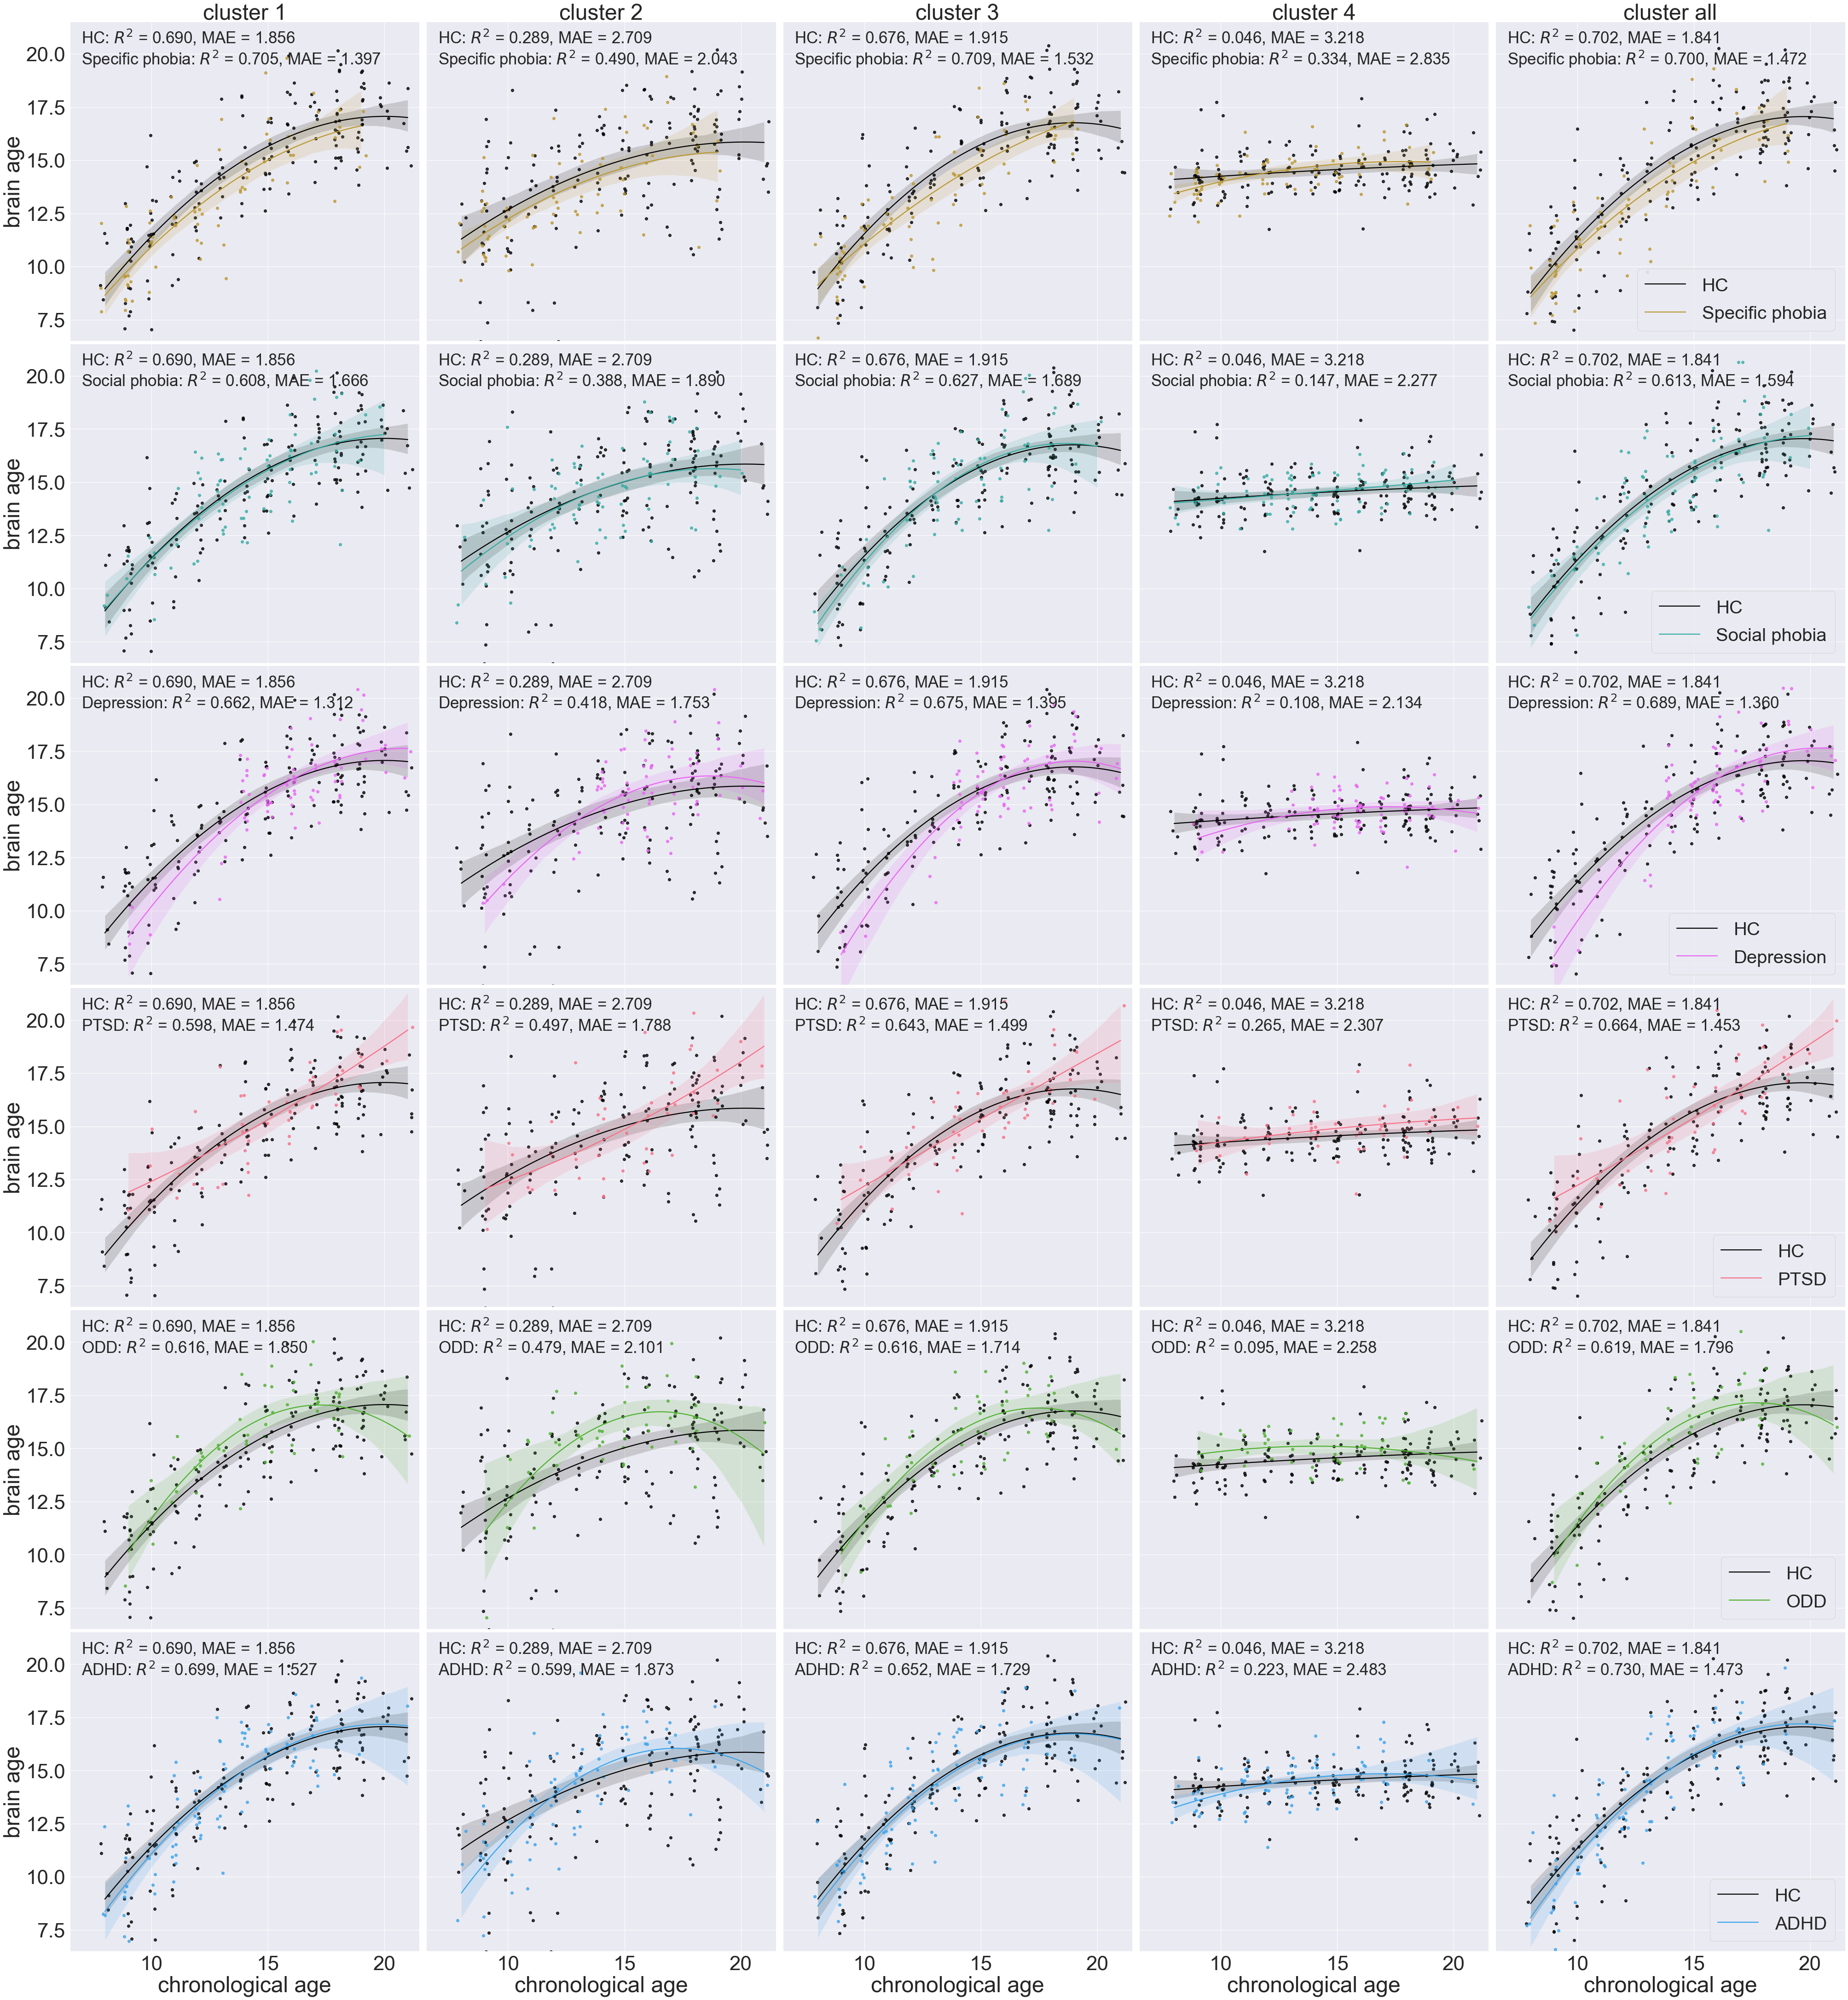

In [25]:
sns.set(rc={'figure.figsize':(9, 8)}, font_scale = 4)
text_size = 35

group_label = ['HC', 'Specific phobia', 'Social phobia', 'Depression', 'PTSD', 'ODD', 'ADHD']
# group_label = ['HC', 'Specific phobia', 'Social anxiety', 'ODD', 'ADHD']

# colors = sns.color_palette("RdBu_r", 7)
colors = [sns.xkcd_rgb["black"]] + sns.color_palette("husl", len(group_label)-1).as_hex()
colors = colors[::2] + colors[1::2] 

scatter_para = {'alpha': 0.9, 's': 3, 'linewidth': 0.1}

def plot_result_disorder(plot_data, group_label):

    plot_data['plot_row'] = 1
    column_title = plot_data['cluster2'].unique().sort_values()
    plot_data_list = []
    for i in range(1, len(group_label)):
        plot_data_i = plot_data[plot_data['group'].isin([group_label[0]]+[group_label[i]])]
        plot_data_i.loc[:,'plot_row'] = i
        plot_data_list.append(plot_data_i)
        
    plot_data_merge = pd.concat(plot_data_list, axis = 0)
    
#     cluster_name = plot_data['cluster'].unique()
#     variable_name = plot_data['group'].unique()

    g = sns.lmplot(x='chronological age', y='brain age', hue = 'group', 
                   col = 'cluster2', row = 'plot_row', palette = colors, 
                   data = plot_data_merge, fit_reg=True, sharex = True, sharey = True, \
                   scatter_kws={'alpha':0.8}, x_jitter = .2, order = 2,\
                   height=10.27, aspect=9.17/8.27, legend = False)

    g.axes[0,0].set_xlim(6.5, 21.5)
    g.axes[0,0].set_ylim(6.5, 21.5)

    # comment this to check if column labels are correct:
    for col in range(len(column_title)):
        g.axes[0, col].set_title(column_title[col])
        for row in range(1,len(group_label)-1):
            g.axes[row, col].set_title('')
    
#     plt.setp(g._legend.get_title(), fontsize=45)
#     g._legend.set_title('')
#     for lh in g._legend.legendHandles[:2]: 
#         lh.set_alpha(1)
#         lh._sizes = [200] 
    
    # add legend for each row:
    for row in range(len(group_label)-1):
        g.axes[row, -1].legend(['HC', group_label[row+1]], loc = 'lower right')
        plt.setp(g.axes[row, -1].get_legend().get_texts(), fontsize='40')
            
    # compute R squared for each group and cluster:
    for col in range(len(column_title)):
        chro_age = plot_data.loc[(plot_data['group']=='HC')&(plot_data['cluster2']==column_title[col]),
                                 'chronological age'].values
        brain_age = plot_data.loc[(plot_data['group']=='HC')&(plot_data['cluster2']==column_title[col]),
                                  'brain age'].values
        gender = plot_data.loc[(plot_data['group']=='HC')&(plot_data['cluster2']==column_title[col]),
                               'Sex'].map({'F':0, 'M':1}).values
        
        label_hc = "HC: $R^2$ = %.3f, MAE = %.3f" % (qudratic_r_squared_gender(chro_age, brain_age, gender), 
                                                     np.mean(np.abs(chro_age - brain_age)))
        
        for row in range(len(group_label)-1):
            chro_age = plot_data.loc[(plot_data['group']==group_label[row+1])&(plot_data['cluster2']==column_title[col]),
                                     'chronological age'].values
            brain_age = plot_data.loc[(plot_data['group']==group_label[row+1])&(plot_data['cluster2']==column_title[col]),
                                      'brain age'].values
            gender = plot_data.loc[(plot_data['group']==group_label[row+1])&(plot_data['cluster2']==column_title[col]),
                                   'Sex'].map({'F':0, 'M':1}).values
            
            label_dis = group_label[row+1]+ ": $R^2$ = %.3f, MAE = %.3f" % (qudratic_r_squared_gender(chro_age, brain_age, gender),
                                                                            np.mean(np.abs(chro_age - brain_age)))
            
            g.axes[row, col].text(7, 20.5, label_hc, fontsize = 35)
            g.axes[row, col].text(7, 19.5, label_dis, fontsize = 35)
        
    plt.subplots_adjust(hspace=0.01, wspace=0.02)


plot_result_disorder(scatter_data, group_label)
plt.savefig(input_dir+'/figure4_scatter_merge_' + method + 'disorder' + model + '.png', dpi=300)